# TGDS Model using Model Design

In [1]:
import context
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import sys, os
from numba import cuda

import src.data.data_preprocessing as util
import src.models.thevenin_lstm_model as lstm

tf.compat.v1.set_random_seed(1)
os.environ["CUDA_VISIBLE_DEVICES"]="0"

2022-09-21 12:12:09.841581: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-21 12:12:09.958626: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-21 12:12:10.349491: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:$LD_LIBRARY_PATH:/home/i40/bielskip/miniconda3/envs/battery-system/lib/:/home/i40/bielskip/miniconda3/envs/battery-system/lib/:/home/i40/bielskip/miniconda3/envs/battery-system/lib/:/home/i4

### Set Hyperparameters

In [2]:
# load general hyperparameters
HYPER_PARAMS =  np.load('../../../models/training_setup/hyperparameters.npy', allow_pickle=True)
HYPER_PARAMS = HYPER_PARAMS.item()

# add aditional model-spefic hyperparameters
model_hyperparameters = {
    'n_features': 3,                  # number of input features
    'd_t': 0.25,                       # current integration factor
    'theory_model': 2228,             # the unique thevenin model ID for which the parameters have been computed
}

# update hyperparameters
HYPER_PARAMS.update(model_hyperparameters)

### Prepare Training/Validation/Test Data

In [3]:
# load training sets dictionary
TRAINING_SETS =  np.load('../../../models/training_setup/training_sets.npy', allow_pickle=True)
TRAINING_SETS = TRAINING_SETS.item()

# select correct training set
training_sets = TRAINING_SETS['10A_all']

# create training data
train_data = []
for set in training_sets:
    set_repeat = [set] * HYPER_PARAMS['num_repeat']
    train_data += set_repeat
    
train_data = np.array(train_data)

# select first profile for validation
validation_profile = [train_data[0]] 

# select arbitrary profile for testing
test_profile = np.random.choice(train_data, 1) 

# prepare input data
X_train, y_train, scalers_train = util.prepare_thevenin_input(HYPER_PARAMS, train_data, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_validation, y_validation, _ = util.prepare_thevenin_input(HYPER_PARAMS, validation_profile, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_test, y_test, _ = util.prepare_thevenin_input(HYPER_PARAMS, test_profile, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])

Input: (46750, 100, 3)  Output/Label: (46750, 1)
Input: (1500, 100, 3)  Output/Label: (1500, 1)
Input: (1850, 100, 3)  Output/Label: (1850, 1)


### Prepare non-sequential Input

In [4]:
cond_train = util.prepare_intermediate_volt(HYPER_PARAMS, train_data, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
cond_validation = util.prepare_intermediate_volt(HYPER_PARAMS, validation_profile, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
cond_test = util.prepare_intermediate_volt(HYPER_PARAMS, test_profile, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])

### Initialize and Train Model

In [5]:
lstm = lstm.Model()
lstm.initialize(HYPER_PARAMS)

2022-09-21 12:12:58.212718: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 12:12:58.233155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 12:12:58.233342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 12:12:58.233872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/5


2022-09-21 12:13:00.371300: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-09-21 12:13:00.741447: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1461/1461 [==============================] - 13s 7ms/step - loss: 3.6440e-04 - mse: 3.6440e-04 - mae: 0.0129
Epoch 2/5
1461/1461 [==============================] - 11s 8ms/step - loss: 2.1126e-04 - mse: 2.1126e-04 - mae: 0.0109
Epoch 3/5
1461/1461 [==============================] - 11s 7ms/step - loss: 2.0017e-04 - mse: 2.0017e-04 - mae: 0.0107
Epoch 4/5
1461/1461 [==============================] - 11s 7ms/step - loss: 1.9596e-04 - mse: 1.9596e-04 - mae: 0.0105
Epoch 5/5
1461/1461 [==============================] - 10s 7ms/step - loss: 1.8173e-04 - mse: 1.8173e-04 - mae: 0.0100
Training time: 55.335s


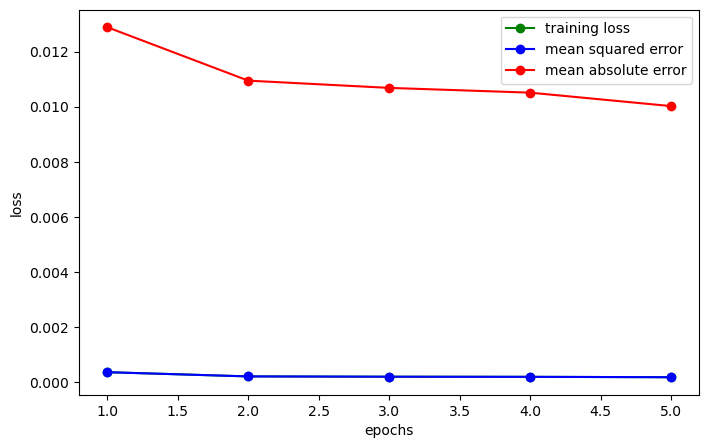

In [6]:
_, fig = lstm.train([X_train, cond_train], y_train, scalers_train)

# save model, hyperparameters and plots
MODEL_ID = str(np.random.randint(10000))

lstm.model.save('../../../models/TGDS/' + str(MODEL_ID))
np.save('../../../models/TGDS/' + str(MODEL_ID) + '/hyperparameters', HYPER_PARAMS)
fig.savefig('../../../reports/figures/theory_guided_variables-' + str(MODEL_ID) + '-learning_curve.png')

### Test Model

Validation Profile: ['Profile 10A']
Test Profile: ['Profile 10A Run 070618']
1461/1461 [==============================] - 5s 3ms/step
Prediction time on Training Set:  4.607s
47/47 [==============================] - 0s 2ms/step
Prediction time on Validation Set:  0.117s
58/58 [==============================] - 0s 2ms/step
Prediction time on Test Set:  0.14s
###########################################################
            Training    Validation    Test
--------  ----------  ------------  ------
MSE (μV)     20.9           8.8     8.5
MAE (V)       0.0036        0.0029  0.0027
MaxE (V)      0.015         0.005   0.0056
###########################################################


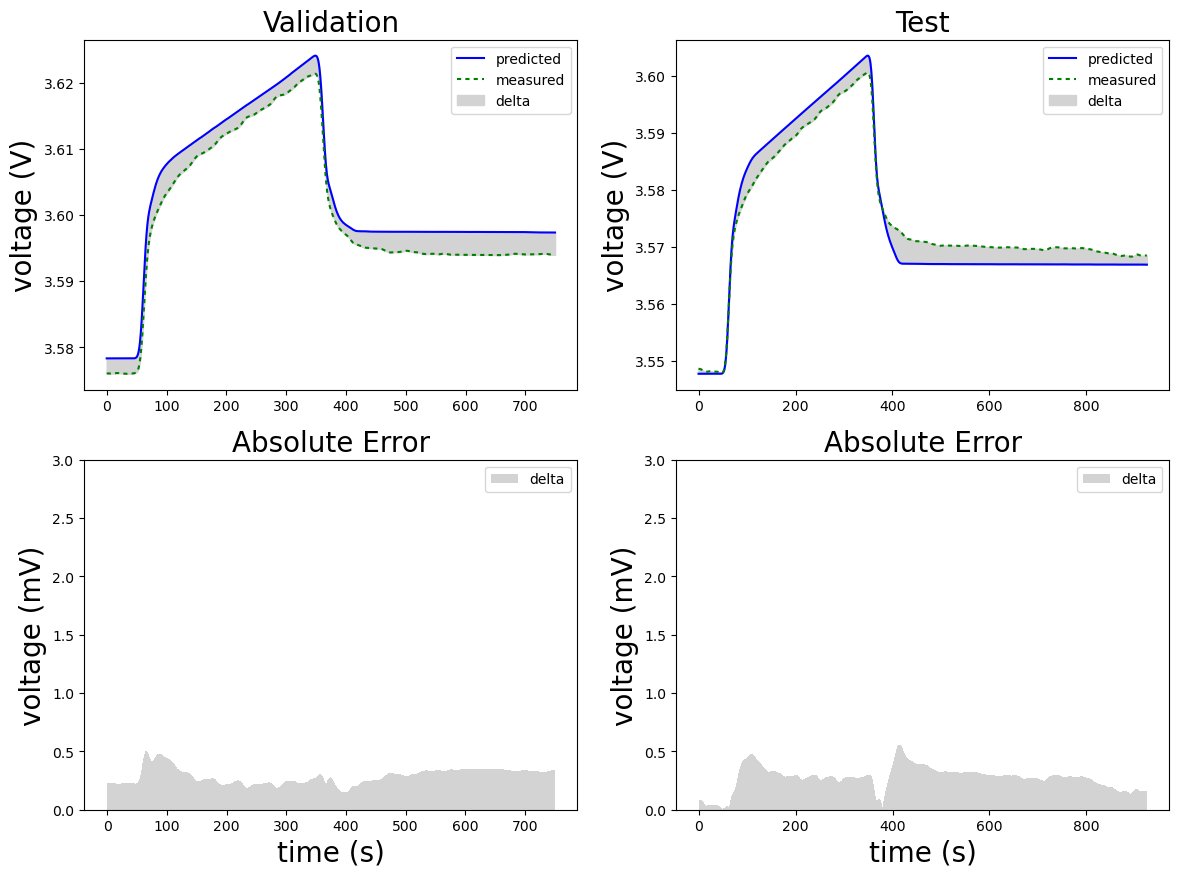

In [7]:
print('Validation Profile:', validation_profile)
print('Test Profile:', test_profile)

yhat_train_unscaled, _, _, fig = lstm.test([X_train, cond_train], y_train, [X_validation, cond_validation], y_validation, [X_test, cond_test], y_test, scalers_train)

# save plots and predicted sequences
np.save('../../../models/TGDS/' + str(MODEL_ID) + '/predictions', yhat_train_unscaled)
fig.savefig('../../../reports/figures/theory_guided_variables-' + str(MODEL_ID) + '-validation&test_profiles.png')

### Prepare Data for Use Cases

In [8]:
# load test sets dictionary
TEST_SETS =  np.load('../../../models/training_setup/test_sets.npy', allow_pickle=True)
TEST_SETS = TEST_SETS.item()

# select needed test profiles
test_profiles_usecase_1 = TEST_SETS['Reproduction']
test_profiles_usecase_2 = TEST_SETS['Abstraction']
test_profiles_usecase_3 = TEST_SETS['Generalization']

# prepare input data
X_case_1, y_case_1, _ = util.prepare_thevenin_input(HYPER_PARAMS, test_profiles_usecase_1, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_case_2, y_case_2, _ = util.prepare_thevenin_input(HYPER_PARAMS, test_profiles_usecase_2, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_case_3, y_case_3, _ = util.prepare_thevenin_input(HYPER_PARAMS, test_profiles_usecase_3, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])

# prepare non-sequential input data
cond_case_1 = util.prepare_intermediate_volt(HYPER_PARAMS, test_profiles_usecase_1, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
cond_case_2 = util.prepare_intermediate_volt(HYPER_PARAMS, test_profiles_usecase_2, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
cond_case_3 = util.prepare_intermediate_volt(HYPER_PARAMS, test_profiles_usecase_3, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])

Input: (1500, 100, 3)  Output/Label: (1500, 1)
Input: (3100, 100, 3)  Output/Label: (3100, 1)
Input: (1600, 100, 3)  Output/Label: (1600, 1)


### Test Model on Use Cases

Use Case 1: ['Profile 10A']
Use Case 2: ['Profile 10A 3x']
Use Case 3: ['Profile -10A']
1461/1461 [==============================] - 5s 4ms/step
Prediction time on Training Set:  5.391s
47/47 [==============================] - 0s 3ms/step
Prediction time on Use Case 1:  0.152s
97/97 [==============================] - 0s 3ms/step
Prediction time on Use Case 2:  0.255s
50/50 [==============================] - 0s 2ms/step
Prediction time on Use Case 3:  0.111s
##############################################################
             Training    Use Case 1    Use Case 2    Use Case 3
---------  ----------  ------------  ------------  ------------
MSE  (μV)     20.9           8.8          27.1          23.8
MAE  (V)       0.0036        0.0029        0.0043        0.0041
MaxE (V)       0.015         0.005         0.0106        0.0074
##############################################################


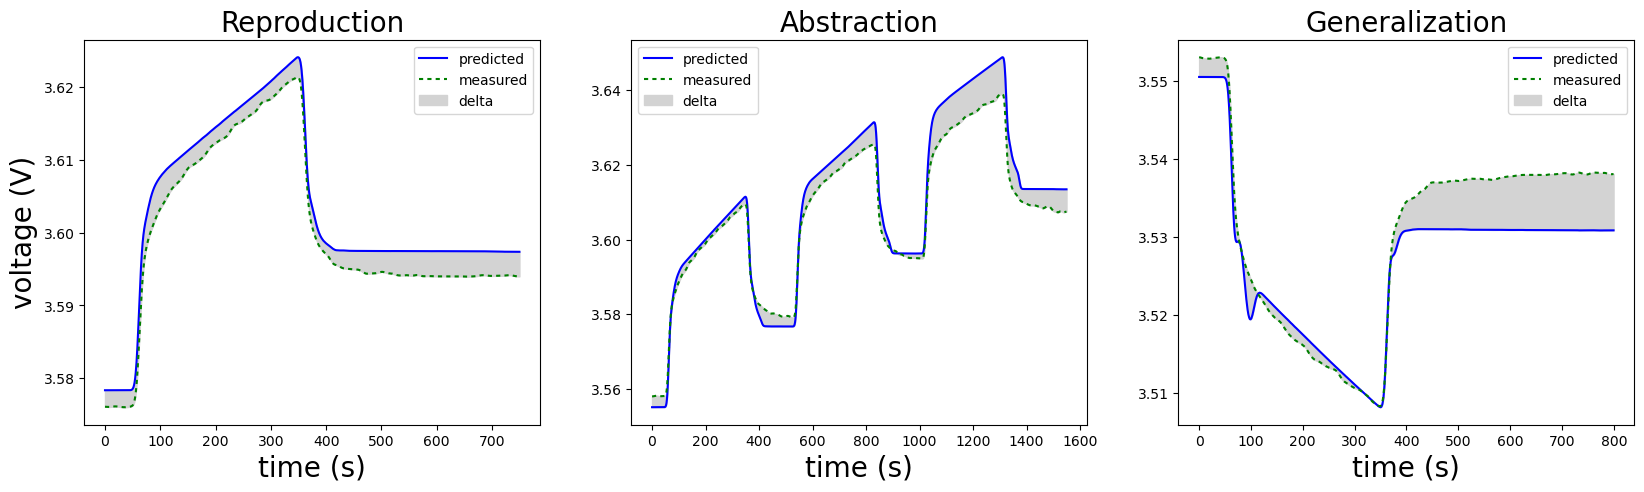

In [9]:
print('Use Case 1:', test_profiles_usecase_1)
print('Use Case 2:', test_profiles_usecase_2)
print('Use Case 3:', test_profiles_usecase_3)

train_mse, case_1_mse, case_2_mse, case_3_mse, fig = lstm.test_usecases([X_train, cond_train], y_train, [X_case_1, cond_case_1], y_case_1, [X_case_2, cond_case_2], y_case_2, [X_case_3, cond_case_3], y_case_3, scalers_train)

In [10]:
fig.savefig('../../../reports/figures/data_baseline-' + str(MODEL_ID) + '-use_cases.png')
columns = ["Name", "Timestamp", "Model ID", "Train MSE", "Case 1 MSE", "Case 2 MSE", "Case 3 MSE"]
df = pd.DataFrame(columns=columns)

timestamp = datetime.datetime.now().isoformat(sep=" ", timespec="seconds")

new_df = pd.DataFrame([["Model Design", timestamp, MODEL_ID, train_mse, case_1_mse, case_2_mse, case_3_mse]], columns=columns)

df = pd.concat(([df, new_df]))
df.to_csv('../../../reports/results/experiments.csv', mode='a', float_format='%.10f', index=False, header=False)

In [11]:
device = cuda.get_current_device()
device.reset()